# Keras for Text Classification

**Learning Objectives**
1. Learn how to create a text classification datasets using BigQuery
1. Learn how to tokenize and integerize a corpus of text for training using Keras preprocessing layers
1. Learn how to do one-hot-encodings in Keras
1. Learn how to use embedding layers to represent words in Keras
1. Learn about the bag-of-word representation for sentences
1. Learn how to use DNN/CNN/RNN model to classify text in keras

## Introduction


In this notebook, we will implement text models to recognize the probable source (GitHub, TechCrunch, or The New York Times) of the titles we have in the title dataset we constructed in the first task of the lab.

In the next step, we will load and pre-process the texts and labels so that they are suitable to be fed to a Keras model. For the texts of the titles we will learn how to preprocess the titles using Keras Preprocessing Layers. Using Keras Preprocessing Layers will let us feed raw data to the model directly. For the labels, we will learn how to one-hot-encode each of the 3 classes into a 3 dimensional basis vector.

Then we will explore a few possible models to do the title classification.

The first model will be a simple bag-of-word DNN model that averages up the word vectors and feeds the tensor that results to further dense layers. Doing so means that we forget the word order (and hence that we consider sentences as a “bag-of-words”). In the second and in the third model we will keep the information about the word order using a simple RNN and a simple CNN allowing us to achieve the same performance as with the DNN model but in much fewer epochs.


In [1]:
import os

import pandas as pd
from google.cloud import bigquery

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


Replace the variable values in the cell below:

In [3]:
PROJECT = !(gcloud config get-value core/project)
PROJECT = PROJECT[0]
%env PROJECT = {PROJECT}
%env BUCKET = {PROJECT}
%env REGION = "us-central1"
SEED = 0

env: PROJECT=sanjana-sandbox-012024
env: BUCKET=sanjana-sandbox-012024
env: REGION="us-central1"


## Create a Dataset from BigQuery 

Hacker news headlines are available as a BigQuery public dataset. The [dataset](https://bigquery.cloud.google.com/table/bigquery-public-data:hacker_news.stories?tab=details) contains all headlines from the sites inception in October 2006 until October 2015. 

Here is a sample of the dataset:

In [4]:
%%bigquery --project $PROJECT

SELECT
    url, title, score
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    LENGTH(title) > 10
    AND score > 10
    AND LENGTH(url) > 0
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,url,title,score
0,http://mindaverse.com/2008/12/18/save-time-wit...,Using a Virtual Assistant to become more produ...,12
1,https://arstechnica.com/gaming/2024/04/a-touch...,Delta takes flight: Apple-approved Nintendo em...,23
2,https://www.discoursemagazine.com/p/zoning-out...,Zoning Out American Families,22
3,https://twitter.com/winglian/status/1783122644...,Llama3 – 65k Context Window with great recall,23
4,https://github.com/gateweaver/gateweaver,Show HN: I've developed an open-source proxy s...,11
5,https://technicshistory.com/2024/04/25/twiligh...,"Twilight of the Age of Steam, Part 2: Petroleu...",17
6,http://venturebeat.com/2012/05/22/jon-radoff-t...,Game of Thrones Anti-Social Game,12
7,https://petapixel.com/2024/04/18/this-viral-ki...,Viral Kickstarter Telephoto Camera Makes Impos...,26
8,http://news.yahoo.com/software-exec-charged-le...,Silicon Valley Exec Caught Stealing Legos from...,11
9,https://www.threads.net/@moskov/post/C6KW_Odvky0,Dustin Moskovitz says Tesla is the next Enron,11


Let's do some regular expression parsing in BigQuery to get the source of the newspaper article from the URL. For example, if the url is http://mobile.nytimes.com/...., I want to be left with <i>nytimes</i>

In [5]:
%%bigquery --project $PROJECT

SELECT
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[SAFE_OFFSET(1)] AS source,
    COUNT(title) AS num_articles
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
GROUP BY
    source
ORDER BY num_articles DESC
  LIMIT 100

Query is running:   0%|          |

Downloading:   0%|          |

,source,num_articles
0,github,185992
1,medium,134639
2,youtube,130422
3,nytimes,85302
4,blogspot,62223
...,...,...
95,nextplatform,3172
96,itworld,3162
97,atlasobscura,3086
98,anandtech,3015


Now that we have good parsing of the URL to get the source, let's put together a dataset of source and titles. This will be our labeled dataset for machine learning.

In [6]:
regex = ".*://(.[^/]+)/"


sub_query = """
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '{0}'), '.'))[SAFE_OFFSET(1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '{0}'), '.com$')
    AND LENGTH(title) > 10
""".format(
    regex
)


query = """
SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  ({sub_query})
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')
""".format(
    sub_query=sub_query
)

print(query)


SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  (
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[SAFE_OFFSET(1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
)
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')



For ML training, we usually need to split our dataset into training and evaluation datasets (and perhaps an independent test dataset if we are going to do model or feature selection based on the evaluation dataset).



In [7]:
bq = bigquery.Client(project=PROJECT)
title_dataset = bq.query(query).to_dataframe()
title_dataset.head()

,title,source
0,onetext yc w23 is hiring a lead ux engineer,github
1,final eurovision predictions from markov chain...,github
2,barber pole progress view for ios,github
3,infinite pixel art canvas on the terminal rus...,github
4,show hn chrome extension for webpage summariz...,github


In [8]:
print(f"The full dataset contains {len(title_dataset)} titles")

The full dataset contains 331267 titles


Let's make sure we have roughly the same number of labels for each of our three labels:

In [9]:
title_dataset.source.value_counts()

source
github        185992
nytimes        85302
techcrunch     59973
Name: count, dtype: int64

Finally we will save our data, which is currently in-memory, to disk.

We will create a csv file containing the full dataset and store it the `data` folder.

In [10]:
DATADIR = "./data/"

if not os.path.exists(DATADIR):
    os.makedirs(DATADIR)

In [11]:
FULL_DATASET_NAME = "titles_full.csv"
FULL_DATASET_PATH = os.path.join(DATADIR, FULL_DATASET_NAME)

# Let's shuffle the data before writing it to disk.
title_dataset = title_dataset.sample(n=len(title_dataset))

title_dataset.to_csv(
    FULL_DATASET_PATH, header=False, index=False, encoding="utf-8"
)

## Text Classification

Now that we have the data as a csv file let's start by importing relavant libraries

In [12]:
import os
import shutil

import keras
import pandas as pd
import tensorflow as tf
from keras import Input
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import (
    GRU,
    Conv1D,
    Dense,
    Embedding,
    Flatten,
    Lambda,
    TextVectorization,
)
from keras.models import Sequential
from keras.utils import to_categorical

2025-08-27 22:34:39.306255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756334079.327654  106416 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756334079.334088  106416 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
%matplotlib inline

Let's start by specifying where the information about the trained models will be saved as well as where our dataset is located:

In [14]:
LOGDIR = "./text_models"
DATA_DIR = "./data"

## Loading the dataset

Our dataset consists of titles of articles along with the label indicating from which source these articles have been taken from (GitHub, TechCrunch, or The New York Times).

In [15]:
DATASET_NAME = "titles_full.csv"
TITLE_SAMPLE_PATH = os.path.join(DATA_DIR, DATASET_NAME)
COLUMNS = ["title", "source"]

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,auto convert media to stickers on whatsapp,github
1,cloud-ssh tiny wrapper for ssh which enchanc...,github
2,my craigslisp chrome plugin,github
3,crypto exchange bybit says it was hacked and l...,techcrunch
4,popular algorithms and exercises in go,github


In [16]:
titles_df.source[:4]

0        github
1        github
2        github
3    techcrunch
Name: source, dtype: object

We now need to write a function that 
* takes a title source and
* returns the corresponding one-hot encoded vector

Keras `to_categorical` is handy for that.

In [17]:
CLASSES = {"github": 0, "nytimes": 1, "techcrunch": 2}
N_CLASSES = len(CLASSES)

In [18]:
# TODO 2


def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = to_categorical(classes)
    return one_hots

In [19]:
encode_labels(titles_df.source[:4])

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

## Preparing the train/test splits

Let's split our data into train and test splits:

In [20]:
DATASET_SIZE = titles_df.shape[0]
N_TRAIN = int(DATASET_SIZE * 0.80)

titles_train, sources_train = (
    titles_df.title[:N_TRAIN],
    titles_df.source[:N_TRAIN],
)

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:],
    titles_df.source[N_TRAIN:],
)

To be on the safe side, we verify that the train and test splits
have roughly the same number of examples per classes.

Since it is the case, accuracy will be a good metric to use to measure
the performance of our models.


In [21]:
sources_train.value_counts()

source
github        148882
nytimes        68101
techcrunch     48030
Name: count, dtype: int64

In [22]:
sources_valid.value_counts()

source
github        37110
nytimes       17201
techcrunch    11943
Name: count, dtype: int64

Using `encode_labels` function, we can now prepare the
training and validation data to feed our models. The labels will be one-hot-encoded 3D vectors.

In [23]:
Y_train = keras.ops.convert_to_tensor(encode_labels(sources_train))
Y_valid = keras.ops.convert_to_tensor(encode_labels(sources_valid))

I0000 00:00:1756334082.594590  106416 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 711 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


In [24]:
Y_train[:3]

<tf.Tensor: shape=(3, 3), dtype=float64, numpy=
array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])>

## Keras Text Preprocessing Layer

Before we start passing data to the model, we need to preprocess the text. Using Keras preprocessing layers we can now include this in the model directly.

The preprocessing that we will be doing:
- Tokenizing the text
- Integerizing the tokens

At instanciation, we can specify the maximum length of the sequence output as well as the maximum number of tokens to be considered

In [25]:
MAX_LEN = 26
MAX_TOKENS = 20000

preprocessing_layer = TextVectorization(
    output_sequence_length=MAX_LEN, max_tokens=MAX_TOKENS
)

Before using this layer in our model, we need to adapt it to our data so that it generates a token-to-integer mapping. Remeber our dataset looks like the following:

In [26]:
titles_df.head()

,title,source
0,auto convert media to stickers on whatsapp,github
1,cloud-ssh tiny wrapper for ssh which enchanc...,github
2,my craigslisp chrome plugin,github
3,crypto exchange bybit says it was hacked and l...,techcrunch
4,popular algorithms and exercises in go,github


We can directly use the Pandas Series corresponding to the titles in our dataset to adapt the data using the `adapt` method:

In [27]:
preprocessing_layer.adapt(titles_df.title)

Now, the preprocessing layer can create the integer representation of our input text if we simply apply the layer to it:

In [28]:
X_train = keras.ops.convert_to_tensor(titles_train)
X_valid = keras.ops.convert_to_tensor(titles_valid)
X_train[:5]

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'auto convert media to stickers on whatsapp',
       b'cloud-ssh   tiny wrapper for ssh which enchance work with cloud providers',
       b'my craigslisp chrome plugin',
       b'crypto exchange bybit says it was hacked and lost around $1.4b',
       b'popular algorithms and exercises in go'], dtype=object)>

In [29]:
integers = preprocessing_layer(X_train[:5])
integers

<tf.Tensor: shape=(5, 26), dtype=int64, numpy=
array([[1039,  578,  226,    4, 8219,   13,  879,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   1,  268,  423,    3,  489,  495,    1,  181,   12,  143, 2453,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [ 116,    1,  185,  162,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [ 491, 1193,    1,  128,   24,  176, 1299,    9,  692,  559, 7199,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [ 949,  683,    9, 3591,    6,   38,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

We will need the `VOCAB_SIZE` when creating the embedding layer in the model. We can get it using this function

In [30]:
VOCAB_SIZE = len(preprocessing_layer.get_vocabulary())
VOCAB_SIZE

20000

## Building a DNN model

The build_dnn_model function below returns a compiled Keras model that implements a simple embedding layer transforming the word integers into dense vectors, followed by a Dense softmax layer that returns the probabilities for each class.


Note that we need to put a custom Keras Lambda layer in between the Embedding layer and the Dense softmax layer to do an average of the word vectors returned by the embedding layer. This is the average that's fed to the dense softmax layer. By doing so, we create a model that is simple but that loses information about the word order, creating a model that sees sentences as "bag-of-words".

In [31]:
def build_dnn_model(embed_dim):
    model = Sequential(
        [
            Input(shape=(1,), dtype="string", name="input_layer"),
            preprocessing_layer,
            Embedding(
                VOCAB_SIZE + 1, embed_dim, input_shape=[MAX_LEN]
            ),  # TODO 3
            Lambda(lambda x: keras.ops.mean(x, axis=1)),  # TODO 4
            Dense(N_CLASSES, activation="softmax"),  # TODO 5
        ]
    )

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

Below we train the model on 100 epochs but adding an `EarlyStopping` callback that will stop the training as soon as the validation loss has not improved after a number of steps specified by `PATIENCE` . Note that we also give the `model.fit` method a Tensorboard callback so that we can later compare all the models using TensorBoard.

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6059 - loss: 0.8461 - val_accuracy: 0.7829 - val_loss: 0.5349
Epoch 2/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8113 - loss: 0.4875 - val_accuracy: 0.8536 - val_loss: 0.3987
Epoch 3/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8615 - loss: 0.3724 - val_accuracy: 0.8716 - val_loss: 0.3390
Epoch 4/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8817 - loss: 0.3167 - val_accuracy: 0.8817 - val_loss: 0.3090
Epoch 5/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8922 - loss: 0.2864 - val_accuracy: 0.8880 - val_loss: 0.2923
Epoch 6/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8999 - loss: 0.2658 - val_accuracy: 0.8913 - val_loss: 0.2807
Epoch 7/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9041 - loss: 0.2524 - val_accuracy: 0.8932 - val_loss: 0.2742
Epoch 8/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9081 - loss: 0.2425 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 26)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 26, 10)         │       200,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 600,131 (2.29 MB)

 Trainable params: 200,043 (781.42 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 400,088 (1.53 MB)

CPU times: user 3min 14s, sys: 24.3 s, total: 3min 38s
Wall time: 1min 51s


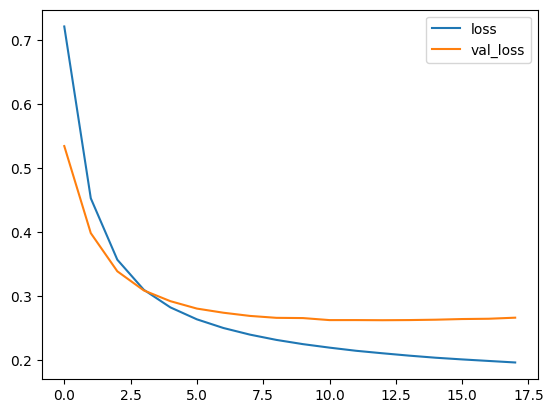

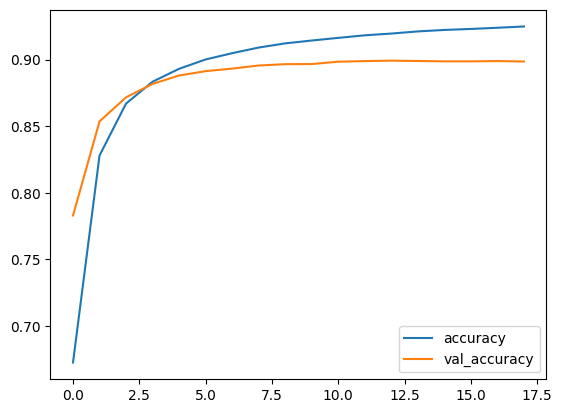

In [32]:
%%time

MODEL_DIR = os.path.join(LOGDIR, "dnn")
shutil.rmtree(MODEL_DIR, ignore_errors=True)

BATCH_SIZE = 300
EPOCHS = 100
EMBED_DIM = 10
PATIENCE = 5

dnn_model = build_dnn_model(embed_dim=EMBED_DIM)


dnn_history = dnn_model.fit(
    X_train,
    Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(dnn_history.history)[["loss", "val_loss"]].plot()
pd.DataFrame(dnn_history.history)[["accuracy", "val_accuracy"]].plot()

dnn_model.summary()

We can have the model directly predict on the input since we are using keras preprocessing layers.

In [33]:
"""
function to get the prediction from the model
model=trained model name
instances=list of instances to get prediction for
"""


def get_predictions(model, instances):
    prediction = model.predict(instances)
    title_prediction = list(zip(instances, prediction))
    for line, predict in title_prediction:
        print(
            "Title: {} \nGithub:{:.2%} \nNYTimes:{:.2%} \nTechCrunch:{:.2%}".format(
                line, float(predict[0]), float(predict[1]), float(predict[2])
            )
        )

In [34]:
get_predictions(dnn_model, X_train[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Title: b'auto convert media to stickers on whatsapp' 
Github:97.79% 
NYTimes:0.32% 
TechCrunch:1.89%
Title: b'cloud-ssh   tiny wrapper for ssh which enchance work with cloud providers' 
Github:100.00% 
NYTimes:0.00% 
TechCrunch:0.00%
Title: b'my craigslisp chrome plugin' 
Github:99.66% 
NYTimes:0.09% 
TechCrunch:0.25%
Title: b'crypto exchange bybit says it was hacked and lost around $1.4b' 
Github:0.04% 
NYTimes:34.06% 
TechCrunch:65.91%
Title: b'popular algorithms and exercises in go' 
Github:94.67% 
NYTimes:5.17% 
TechCrunch:0.16%


## Building a RNN model

The `build_dnn_model` function below returns a compiled Keras model that implements a simple RNN model with a single `GRU` layer, which now takes into account the word order in the sentence.

The first and last layers are the same as for the simple DNN model.

Note that we set `mask_zero=True` in the `Embedding` layer so that the padded words (represented by a zero) are ignored by this and the subsequent layers.


In [42]:
def build_rnn_model(embed_dim, units):
    model = Sequential(
        [
            Input(shape=(1,), dtype="string"),
            preprocessing_layer,
            Embedding(
                VOCAB_SIZE + 1, embed_dim, input_shape=[MAX_LEN], mask_zero=True
            ),  # TODO 3
            GRU(units, use_cudnn=False),  # TODO 5
            Dense(N_CLASSES, activation="softmax"),
        ]
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

Let's train the model with early stoping as above. 

Observe that we obtain the same type of accuracy as with the DNN model, but in less epochs (~3 v.s. ~20 epochs):

In [ ]:
%%time

MODEL_DIR = os.path.join(LOGDIR, "rnn")
shutil.rmtree(MODEL_DIR, ignore_errors=True)

EPOCHS = 100
BATCH_SIZE = 300
EMBED_DIM = 10
UNITS = 16
PATIENCE = 2

rnn_model = build_rnn_model(embed_dim=EMBED_DIM, units=UNITS)

history = rnn_model.fit(
    X_train,
    Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(history.history)[["loss", "val_loss"]].plot()
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot()

rnn_model.summary()

Epoch 1/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 52s 56ms/step - accuracy: 0.5622 - loss: 0.9834 - val_accuracy: 0.7637 - val_loss: 0.5408
Epoch 2/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 49s 55ms/step - accuracy: 0.7710 - loss: 0.5081 - val_accuracy: 0.7828 - val_loss: 0.4588
Epoch 3/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 49s 56ms/step - accuracy: 0.7879 - loss: 0.4389 - val_accuracy: 0.7907 - val_loss: 0.4297
Epoch 4/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 48s 54ms/step - accuracy: 0.7944 - loss: 0.4125 - val_accuracy: 0.7992 - val_loss: 0.4134
Epoch 5/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 48s 54ms/step - accuracy: 0.8051 - loss: 0.3953 - val_accuracy: 0.8087 - val_loss: 0.4019
Epoch 6/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 48s 54ms/step - accuracy: 0.8189 - loss: 0.3799 - val_accuracy: 0.8203 - val_loss: 0.3905
Epoch 7/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 48s 55ms/step - accuracy: 0.8331 - loss: 0.3615 - val_accuracy: 0.8368 - val_loss: 0.3739
Epoch 8/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 48s 54ms/step - accuracy: 0.8557 - loss: 0

In [37]:
get_predictions(rnn_model, X_train[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Title: b'auto convert media to stickers on whatsapp' 
Github:35.54% 
NYTimes:32.50% 
TechCrunch:31.96%
Title: b'cloud-ssh   tiny wrapper for ssh which enchance work with cloud providers' 
Github:35.42% 
NYTimes:32.33% 
TechCrunch:32.24%
Title: b'my craigslisp chrome plugin' 
Github:35.36% 
NYTimes:32.35% 
TechCrunch:32.29%
Title: b'crypto exchange bybit says it was hacked and lost around $1.4b' 
Github:34.48% 
NYTimes:33.34% 
TechCrunch:32.18%
Title: b'popular algorithms and exercises in go' 
Github:36.04% 
NYTimes:32.31% 
TechCrunch:31.65%


## Build a CNN model

The `build_dnn_model` function below returns a compiled Keras model that implements a simple CNN model with a single `Conv1D` layer, which now takes into account the word order in the sentence.

The first and last layers are the same as for the simple DNN model, but we need to add a `Flatten` layer betwen the convolution and the softmax layer.

Note that we set `mask_zero=True` in the `Embedding` layer so that the padded words (represented by a zero) are ignored by this and the subsequent layers.


In [38]:
def build_cnn_model(embed_dim, filters, ksize, strides):
    model = Sequential(
        [
            Input(shape=(1,), dtype="string"),
            preprocessing_layer,
            Embedding(
                VOCAB_SIZE + 1, embed_dim, input_shape=[MAX_LEN], mask_zero=True
            ),  # TODO 3
            Conv1D(  # TODO 5
                filters=filters,
                kernel_size=ksize,
                strides=strides,
                activation="relu",
            ),
            Flatten(),  # TODO 5
            Dense(N_CLASSES, activation="softmax"),
        ]
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

Let's train the model. 

Again we observe that we get the same kind of accuracy as with the DNN model but in many fewer steps.



Epoch 1/100


/home/jupyter/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


884/884 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.5901 - loss: 0.8991 - val_accuracy: 0.7618 - val_loss: 0.5024
Epoch 2/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7739 - loss: 0.4704 - val_accuracy: 0.8066 - val_loss: 0.4216
Epoch 3/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8163 - loss: 0.4038 - val_accuracy: 0.8316 - val_loss: 0.3851
Epoch 4/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8398 - loss: 0.3653 - val_accuracy: 0.8462 - val_loss: 0.3617
Epoch 5/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8541 - loss: 0.3408 - val_accuracy: 0.8578 - val_loss: 0.3432
Epoch 6/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8672 - loss: 0.3185 - val_accuracy: 0.8672 - val_loss: 0.3268
Epoch 7/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8784 - loss: 0.2996 - val_accuracy: 0.8746 - val_loss: 0.3116
Epoch 8/100
884/884 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8881 - loss: 0.2799 - val_accuracy: 0.8809

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 26)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 26, 5)          │       100,005 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 12, 200)        │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         7,203 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 331,226 (1.26 MB)

 Trainable params: 110,408 (431.28 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 220,818 (862.57 KB)

CPU times: user 3min 36s, sys: 25.5 s, total: 4min 2s
Wall time: 2min 13s


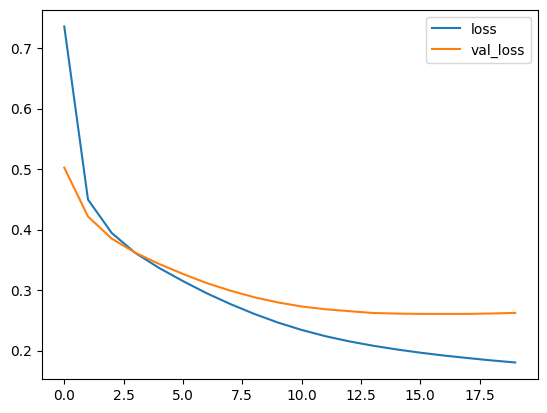

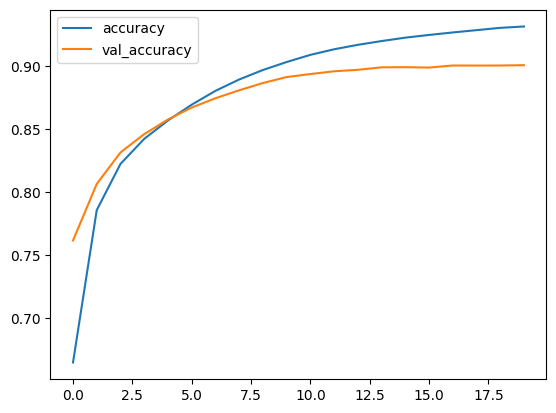

In [39]:
%%time

MODEL_DIR = os.path.join(LOGDIR, "cnn")
shutil.rmtree(MODEL_DIR, ignore_errors=True)

EPOCHS = 100
BATCH_SIZE = 300
EMBED_DIM = 5
FILTERS = 200
STRIDES = 2
KSIZE = 3
PATIENCE = 2


cnn_model = build_cnn_model(
    embed_dim=EMBED_DIM,
    filters=FILTERS,
    strides=STRIDES,
    ksize=KSIZE,
)

cnn_history = cnn_model.fit(
    X_train,
    Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(cnn_history.history)[["loss", "val_loss"]].plot()
pd.DataFrame(cnn_history.history)[["accuracy", "val_accuracy"]].plot()

cnn_model.summary()

In [40]:
get_predictions(cnn_model, X_train[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Title: b'auto convert media to stickers on whatsapp' 
Github:97.39% 
NYTimes:0.65% 
TechCrunch:1.96%
Title: b'cloud-ssh   tiny wrapper for ssh which enchance work with cloud providers' 
Github:100.00% 
NYTimes:0.00% 
TechCrunch:0.00%
Title: b'my craigslisp chrome plugin' 
Github:99.62% 
NYTimes:0.12% 
TechCrunch:0.26%
Title: b'crypto exchange bybit says it was hacked and lost around $1.4b' 
Github:0.30% 
NYTimes:38.57% 
TechCrunch:61.13%
Title: b'popular algorithms and exercises in go' 
Github:93.68% 
NYTimes:6.03% 
TechCrunch:0.30%


/home/jupyter/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License